In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
#EXERCISE 2

In [3]:
import wrds
db=wrds.Connection(wrds_username='joe')
from datetime import datetime
#db.create_pgpass_file()



data=db.raw_sql("select  permco, date,ret "
           "from crsp.dsf "
           "where permco in (7,35048,8048,21446,20792) "
           "and date>='1999-12-31'"
            "and date<='2018-12-31'")
data.to_csv('data.csv', sep=';', index=False)

Loading library list...
Done


In [4]:
from datetime import datetime
import pandas as pd
data = pd.read_csv("data.csv", sep=';')   
#data['date']=pd.to_datetime(data['date'], format='%Y-%m-%d')


data.loc[data.permco ==7, 'ticker'] = 'AAPL' 
data.loc[data.permco ==35048, 'ticker'] = 'GS' 
data.loc[data.permco ==8048, 'ticker'] = 'MSFT' 
data.loc[data.permco ==21446, 'ticker'] = 'PG' 
data.loc[data.permco ==20792, 'ticker'] = 'GE' 
del data['permco']
data=data.set_index(['date','ticker'])
data_win=data[abs(data['ret']) < 0.04]



 Simple and windsorized mean and variance:


,Mean,Variance,Wind.Mean,Wind.Variance
ticker,,,,
AAPL,0.001167,0.000666,0.000706,0.000262
GE,-0.000092,0.000377,0.000047,0.000185
GS,0.000438,0.000547,0.000297,0.000233
MSFT,0.000388,0.000371,0.000309,0.000192
PG,0.000306,0.000178,0.000336,0.000110


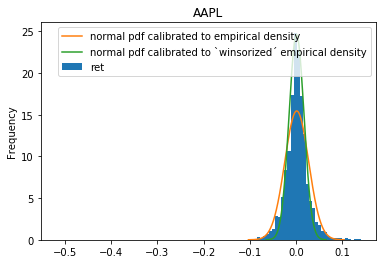

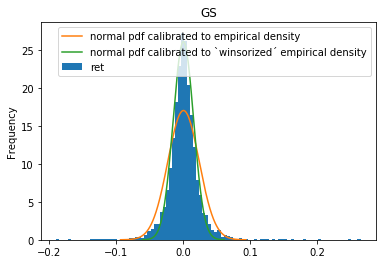

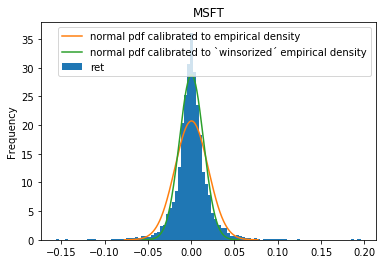

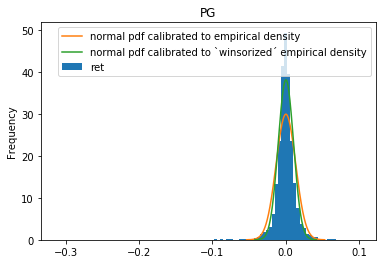

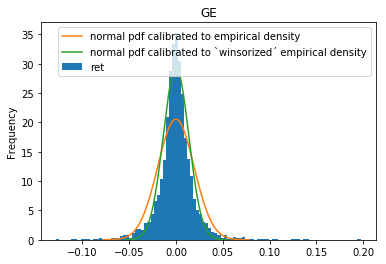


 95% VaR and 99% Var (empirical + normal r.v. with moments matched to empirical distribution):


,95%,95% Normal,99%,99% Normal
ticker,,,,
AAPL,-3.80%,-4.13%,-6.41%,-5.89%
GE,-2.92%,-3.20%,-5.63%,-4.53%
GS,-3.38%,-3.80%,-6.24%,-5.40%
MSFT,-2.83%,-3.13%,-5.47%,-4.44%
PG,-1.74%,-2.16%,-3.44%,-3.07%


In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm


S=['AAPL','GS','MSFT','PG','GE']



#(b) Compute the annualized empirical mean and variance of returns
dt=1.0/252.0 #the data is daily
dt=1.0 #the data is daily
df_stats = pd.DataFrame({'Mean' : data.groupby(pd.Grouper(level='ticker'))['ret'].mean()/dt, 
                       'Variance' : data.groupby(pd.Grouper(level='ticker'))['ret'].var()/dt,
                       'Wind.Mean' : data_win.groupby(pd.Grouper(level='ticker'))['ret'].mean()/dt, 
                       'Wind.Variance' : data_win.groupby(pd.Grouper(level='ticker'))['ret'].var()/dt
                      })

print('\n Simple and windsorized mean and variance:')
display(df_stats)

#Define the normal pdf
def normdens(x,m,s2):
    return np.exp(-0.5*(x-m)**2/s2)/np.sqrt(2*np.pi*s2)

#(c) Compute the empirical distribution function for each stock
for stock in S:
    data.iloc[data.index.get_level_values('ticker') == stock].plot.hist(bins=100,normed=True,label='empirical density')
    x=np.linspace(-4*np.sqrt(df_stats.loc[stock]['Variance']*dt),+4*np.sqrt(df_stats.loc[stock]['Variance']*dt),500)
    y=normdens(x,df_stats.loc[stock]['Mean']*dt,df_stats.loc[stock]['Variance']*dt)
    plt.plot(x,y,label='normal pdf calibrated to empirical density')
    x=np.linspace(-4*np.sqrt(df_stats.loc[stock]['Wind.Variance']*dt),+4*np.sqrt(df_stats.loc[stock]['Wind.Variance']*dt),500)
    y=normdens(x,df_stats.loc[stock]['Wind.Mean']*dt,df_stats.loc[stock]['Wind.Variance']*dt)
    plt.plot(x,y,label='normal pdf calibrated to `winsorized´ empirical density')
    plt.title(stock)
    plt.legend()
    plt.show()
    

#(d) Compute the 95% and 99% VaR
VaR = pd.DataFrame({'95%' : data.groupby(pd.Grouper(level='ticker'))['ret'].quantile(0.05), 
                    '99%' : data.groupby(pd.Grouper(level='ticker'))['ret'].quantile(0.01),
                    '95% Normal' : norm.ppf(0.05, df_stats['Mean']*dt, np.sqrt(df_stats['Variance']*dt)), 
                    '99% Normal' : norm.ppf(0.01, df_stats['Mean']*dt, np.sqrt(df_stats['Variance']*dt)) 
                      })
print('\n 95% VaR and 99% Var (empirical + normal r.v. with moments matched to empirical distribution):')
#VaR= VaR.set_index(S)
display(VaR.style.format("{:.2%}"))


EX2 (e):
--------------------------------------------------
We notice that the normal distribution 
does not characterize appropriately the distribution 
of daily stock returns.
If we include all returns,
the distribution does not fit well
the center of the distribution:
It overestimates the probability
of moderate moves.
This can also be seen from the fact
that the calibrated normal distribution 
overestimates the 95%-VaR
(but underestimates the 99%-VaR).

On the other hand,
if we winsorize the data
by filtering out the "extreme moves",
we fit well the center of the distribution
but significantly underestimate 
the probability of large moves.
This difficulty arises from the fact that
the distribution of daily stock returns
are characterized by "fat tails":
large daily returns occur much more frequently 
than the normal distribution would predict.

A better model of daily stock returns
would have a "diffusion" part 
(for example, a geometric brownian motion)
which would be calibrated to match
the returns excluding large swings.
Then, we would account separately
for the large but infrequent swings
by adding jumps to the stochastic process.
Such models are called
"jump-diffusion models".


In [6]:
#EXERCISE 3

In [8]:
#This code loads the MSCI.csv file, 
#which has the dates in the first column,
#and the seven MSCI indices in columns 2 to 8
#The data is in index level. 
#S=pd.read_csv('MSCI.csv',delimiter=',',index_col='Date')
xl=pd.ExcelFile('MSCI.xlsx')
S=xl.parse('MSCI')
S=S.set_index('Date')
pd.to_datetime(S.index)


DatetimeIndex(['1987-12-31', '1988-01-29', '1988-02-29', '1988-03-31',
               '1988-04-29', '1988-05-31', '1988-06-30', '1988-07-29',
               '1988-08-31', '1988-09-30',
               ...
               '2015-05-29', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-30', '2015-11-30', '2015-12-31',
               '2016-01-29', '2016-02-29'],
              dtype='datetime64[ns]', name='Date', length=339, freq=None)

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import skew
from scipy.stats import kurtosis as stats_kurt
from scipy.stats.mstats import gmean as mean_geo
#from scipy.stats import mstats as stats_m

#compute monthly returns
ret=np.divide(S[1:],S[:-1])-1;
N=len(ret.iloc[0,:])

#compute basic summary statistics
stats=ret.describe()
print(type(ret))

#compute geometric mean
MSCI_geo = mean_geo(1+ret)-1
df = pd.DataFrame([MSCI_geo], columns=list(stats.columns.values))
tmp = stats.append(df)
stats.loc['mean (g)'] = tmp.iloc[-1]

#compare with theoretical approximation
MSCI_mean = stats.loc['mean',:]
MSCI_var = stats.loc['std',:]**2
MSCI_geo_approx = MSCI_mean-0.5*MSCI_var
df = pd.DataFrame([MSCI_geo_approx], columns=list(stats.columns.values))
tmp = stats.append(df)
stats.loc['mean (g, approx.)'] = tmp.iloc[-1]

#compute skew
MSCI_skew = skew(ret, axis=0, bias=True)
df = pd.DataFrame([MSCI_skew], columns=list(stats.columns.values))
tmp = stats.append(df)
stats.loc['skew'] = tmp.iloc[-1]

#compute kurtosis
MSCI_kurt = stats_kurt(ret, axis=0, bias=True)
df = pd.DataFrame([MSCI_kurt], columns=list(stats.columns.values))
tmp = stats.append(df)
stats.loc['kurt'] = tmp.iloc[-1]

#compute 95% VaR
MSCI_VaR = []
for i in range(7):
    MSCI_VaR.append(np.percentile(ret.iloc[:,i],5))
df = pd.DataFrame([MSCI_VaR], columns=list(stats.columns.values))
tmp = stats.append(df)
stats.loc['VaR'] = tmp.iloc[-1]

display(stats)

<class 'pandas.core.frame.DataFrame'>


,US,Japan,Switzerland,Germany,EM Asia,EM Latin America,EM Europe and Middle East
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000
mean,0.008921,0.002219,0.009675,0.008739,0.008125,0.015223,0.005545
std,0.041746,0.059912,0.049289,0.065945,0.069911,0.087954,0.081948
min,-0.171016,-0.193824,-0.156315,-0.243514,-0.240536,-0.346882,-0.320464
25%,-0.016577,-0.039901,-0.017580,-0.026356,-0.027359,-0.034377,-0.042664
50%,0.012908,-0.000481,0.010976,0.011775,0.008829,0.021545,0.008395
75%,0.036092,0.042490,0.039265,0.047939,0.052258,0.068333,0.053748
max,0.114259,0.242602,0.166842,0.236926,0.221226,0.284986,0.414242
mean (g),0.008044,0.000440,0.008461,0.006531,0.005664,0.011250,0.002165
"mean (g, approx.)",0.008050,0.000424,0.008461,0.006564,0.005681,0.011355,0.002188


US


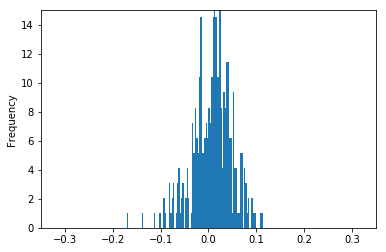

Japan


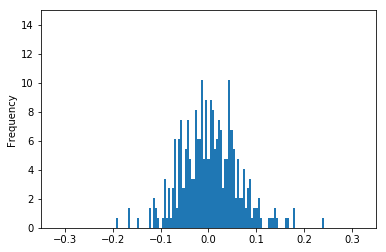

Switzerland


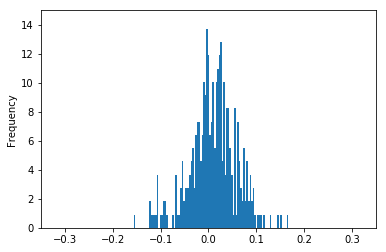

Germany


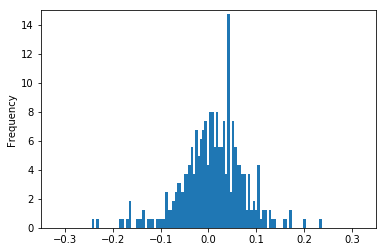

EM Asia


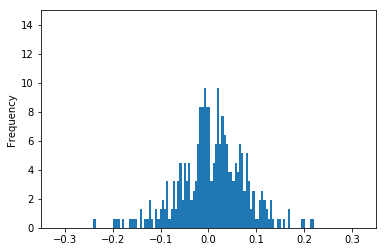

EM Latin America


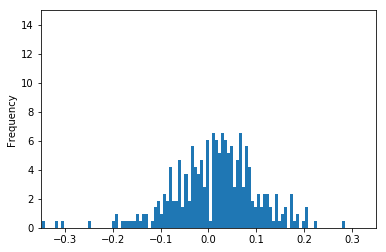

EM Europe and Middle East


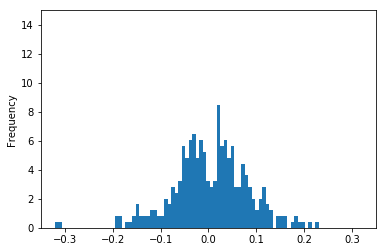

In [10]:
#Now we compute the empirical distribution function for each index
for index in list(ret):
    print(index)
    ret[index].plot.hist(bins=100,normed=True)
    #x=np.linspace(-4*np.sqrt(MSCI_var[index]),+4*np.sqrt(MSCI_var[index]),500)
    #y=normdens(x,MSCI_mean[index],MSCI_var[index])
    #plt.plot(x,y)
    plt.ylim(0,15)
    plt.xlim(-0.35,0.35)
    plt.show()
   

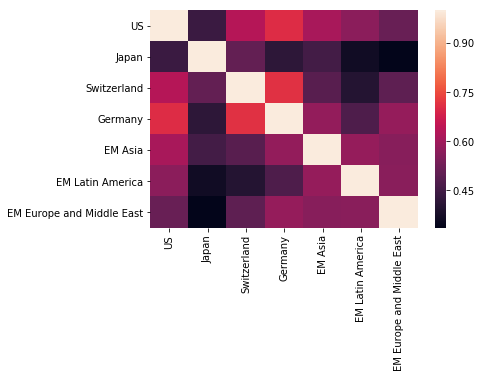

In [11]:
import seaborn as sns
corr_ALL = ret.corr()
sns.heatmap(corr_ALL, 
    xticklabels=corr_ALL.columns.values,
    yticklabels=corr_ALL.columns.values)
plt.show()


In [12]:
import seaborn as sns

corr_DM = ret.iloc[:,0:4].corr()
display(corr_DM.style.format("{:.2%}"))

col_idx = [2,4,5,6]
corr_EM = ret.iloc[:,col_idx].corr()
display(corr_EM.style.format("{:.2%}"))

N_DM = 3
avg_corr_DM = corr_DM.loc['Switzerland',:]
avg_corr_DM = (avg_corr_DM.sum()-1)/N_DM
print('The average correlation between Swiss and DM markets is: '+str(np.around(avg_corr_DM,4)))

N_EM = 3
avg_corr_EM = corr_EM.loc['Switzerland',:]
avg_corr_EM = (avg_corr_EM.sum()-1)/N_EM
print('The average correlation between Swiss and EM markets is: '+str(np.around(avg_corr_EM,4)))


,US,Japan,Switzerland,Germany
US,100.00%,43.85%,63.26%,70.62%
Japan,43.85%,100.00%,50.52%,41.49%
Switzerland,63.26%,50.52%,100.00%,71.43%
Germany,70.62%,41.49%,71.43%,100.00%


,Switzerland,EM Asia,EM Latin America,EM Europe and Middle East
Switzerland,100.00%,48.88%,39.85%,49.67%
EM Asia,48.88%,100.00%,58.45%,56.39%
EM Latin America,39.85%,58.45%,100.00%,56.67%
EM Europe and Middle East,49.67%,56.39%,56.67%,100.00%


The average correlation between Swiss and DM markets is: 0.6174
The average correlation between Swiss and EM markets is: 0.4614


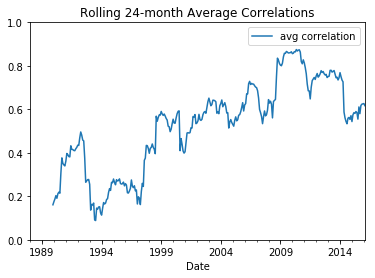

In [13]:
ts_corr= ret.rolling(window=24,min_periods=24).corr()

mask = np.triu_indices(corr_ALL.shape[1], k=1)
dates = ret.index.get_level_values(0)

avgs = [ts_corr.loc[date].values[mask].mean() 
        for date in dates]
ts_avg_corr = pd.Series(avgs, index=dates)

ts_avg_corr.plot(label='avg correlation',title='Rolling 24-month Average Correlations')
plt.ylim((0,1))
plt.legend()
plt.show() 

EX3 (b):
--------------------------------------------------
Note that emerging market returns tend to have higher standard deviations and higher VaR's. 
Their minimums and maximums are also more extreme
compared to developed markets. 
EM equities represent riskier investments compared to DM equities.

EX3 (c):
--------------------------------------------------
As can be seen by comparing the approximations to the exact geometric means, 
the approximation works very well in this dataset.

EX3 (d):
--------------------------------------------------
Swiss returns are less correlated on average with emerging markets returns
(average correlation: 0.46) than with developed markets returns 
(average correlation: 0.62). 
The category of EM equities thus provide better diversification opportunities 
for a Swiss-based investor.

EX3 (e):
--------------------------------------------------
There is a general uptrend in the average correlation across all markets. 
This could be explained as follows.
First, the significant increase in international trade over the last two decades 
has made the macroeconomies of many countries more interdependent. 
Second, capital markets are now more interconnected 
(e.g. due to the opening of EM economies to foreign capital flows,
and the development of new financial products 
such as ETFs that facilitate access to EM markets.) 
As a consequence, the benefits of international diversification for investors 
has probably declined in the recent past.

Note that the average correlation peaks duing the Financial Crisis of 2008-09. 
One potential reason is the presence of levered investors 
who invest in several markets simultaneously. 
When markets decline, 
a portion of their equity is wiped out. 
As a result, they receive margin calls from their lenders 
in order to maintain the loan-to-value (LtV) at acceptable levels. 
If these investors are unable to obtain a capital infusion, 
they are forced to deleverage by selling some of their investments. 
These "forced deleveragings" is arguably an important source of contagion 
across different assets or even asset classes. 
To conclude, this figure provides some support for the claim that diversification disappears 
when it is the most valuable:
during a financial crisis, 
when investors incur significant losses on their equity investments.